# Prepare data

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from ament_index_python.packages import get_package_share_directory


# Define the file path
oscillations_file = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "hardware_signal_response.csv",
)


# Define the target columns for X and Y data
x_columns = [
    "/effort_control/data.0",
    "/joint_states/joint0/position",
    "/joint_states/joint0/velocity",
    "/joint_states/joint1/position",
    "/joint_states/joint1/velocity",
]
y_columns = [
    "/joint_states/joint0/position",
    "/joint_states/joint0/velocity",
    "/joint_states/joint1/position",
    "/joint_states/joint1/velocity",
]
y_labels = [
    "velocity",
    "acceleration",
    "velocity",
    "acceleration",
]

# Define the starting index
starting_idx = 2400

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, x_columns, y_columns, starting_idx):
        self.time_col = "/joint_states/header/stamp"
        self.x_columns = x_columns
        self.y_columns = y_columns

        # Read only the necessary columns
        self.data = pd.read_csv(
            csv_file,
            skiprows=range(1, starting_idx),
            usecols=self.x_columns + [self.time_col],
        )

        # Modify and preprocess data
        self.modify_data()
        self.remove_nan()
        self.normalize_data()

    def __len__(self):
        return len(self.data) - 1  # Exclude the last element

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        next_sample = self.data.iloc[idx + 1]

        x_data = torch.tensor(sample[self.x_columns], dtype=torch.float32)

        # Extract Y data (derivative)
        # dt = next_sample[self.time_col] - sample[self.time_col]
        # y_derivative = torch.tensor(
        #     [(next_sample[col] - sample[col]) / dt for col in self.y_columns],
        #     dtype=torch.float32,
        # )

        # return x_data, y_derivative

        y_data = torch.tensor(next_sample[self.y_columns], dtype=torch.float32)

        return x_data, y_data

    def modify_data(self):
        last_value = 0.0
        for idx, row in self.data.iterrows():
            if np.isnan(row["/effort_control/data.0"]):
                row["/effort_control/data.0"] = last_value
            else:
                last_value = row["/effort_control/data.0"]

    def remove_nan(self):
        self.data.dropna(inplace=True)

    def normalize_data(self):
        # Calculate the offset values based on the first row
        offset_values = self.data.iloc[0][self.x_columns]

        # Subtract the offset values from each corresponding column
        self.data[self.x_columns] -= offset_values


# Create the custom dataset
dataset = CustomDataset(oscillations_file, x_columns, y_columns, starting_idx)

In [4]:
for i in [0, int(len(dataset) / 10), int(len(dataset) / 2)]:
    x_data, y_data = dataset[i]
    print(x_data)

tensor([0., 0., 0., 0., 0.])
tensor([ 0.0000,  2.7145,  4.0267, -0.0046, -2.1092])
tensor([ 0.0000,  7.5299,  0.0000, -0.4005, -5.8483])


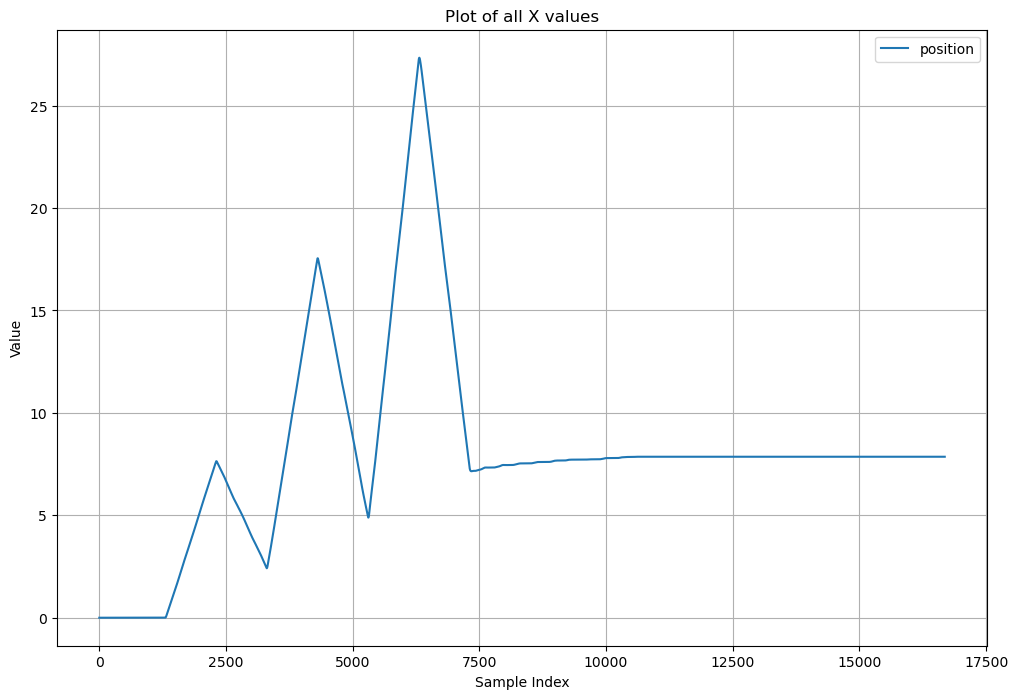

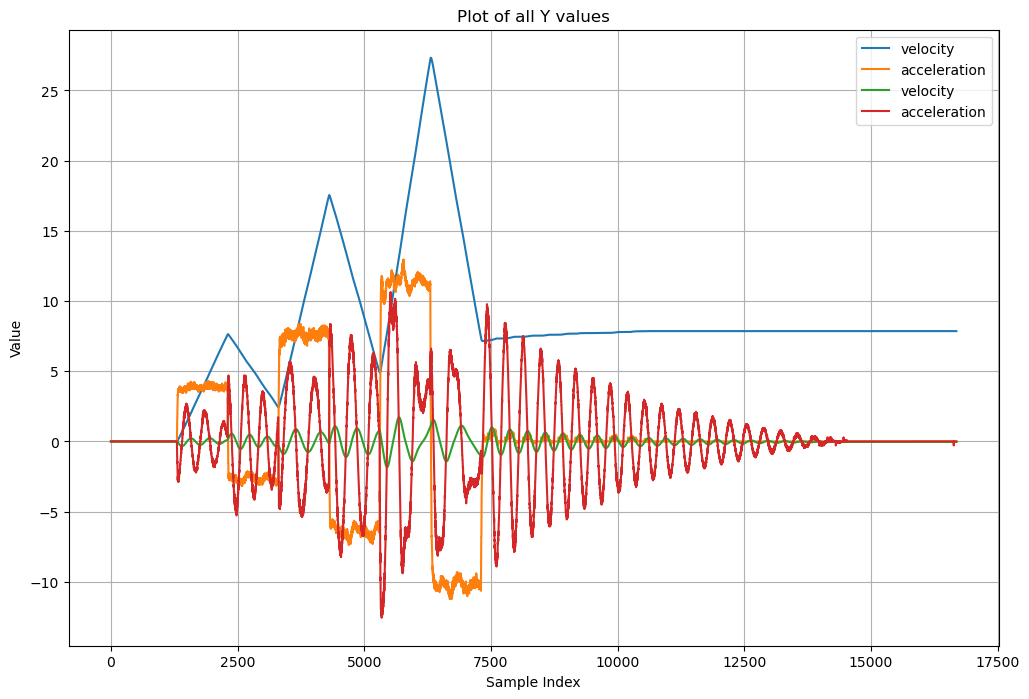

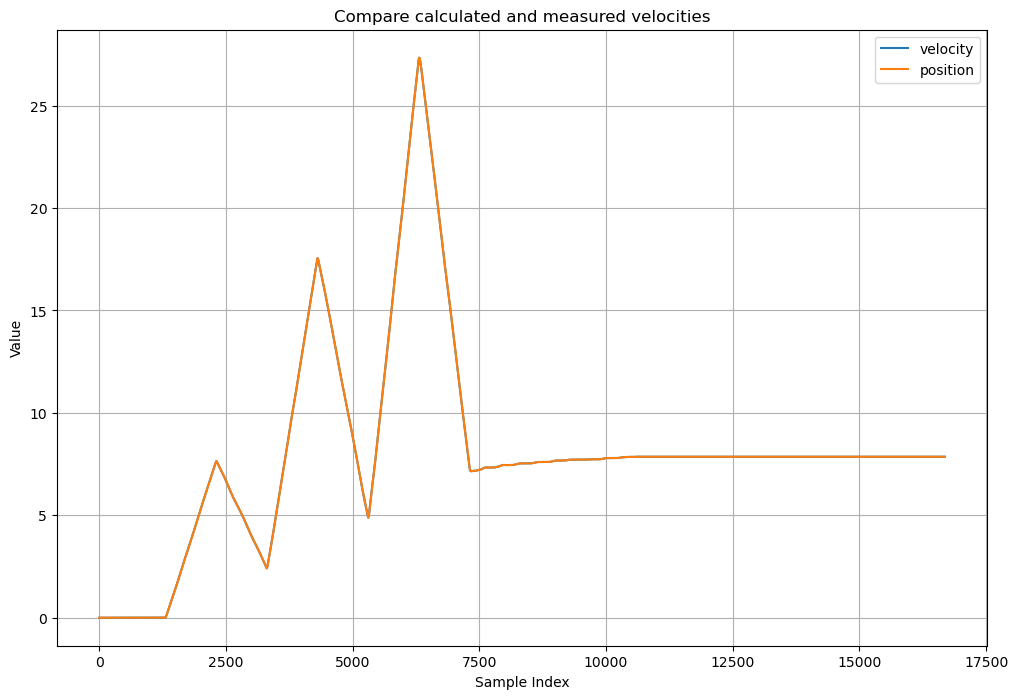

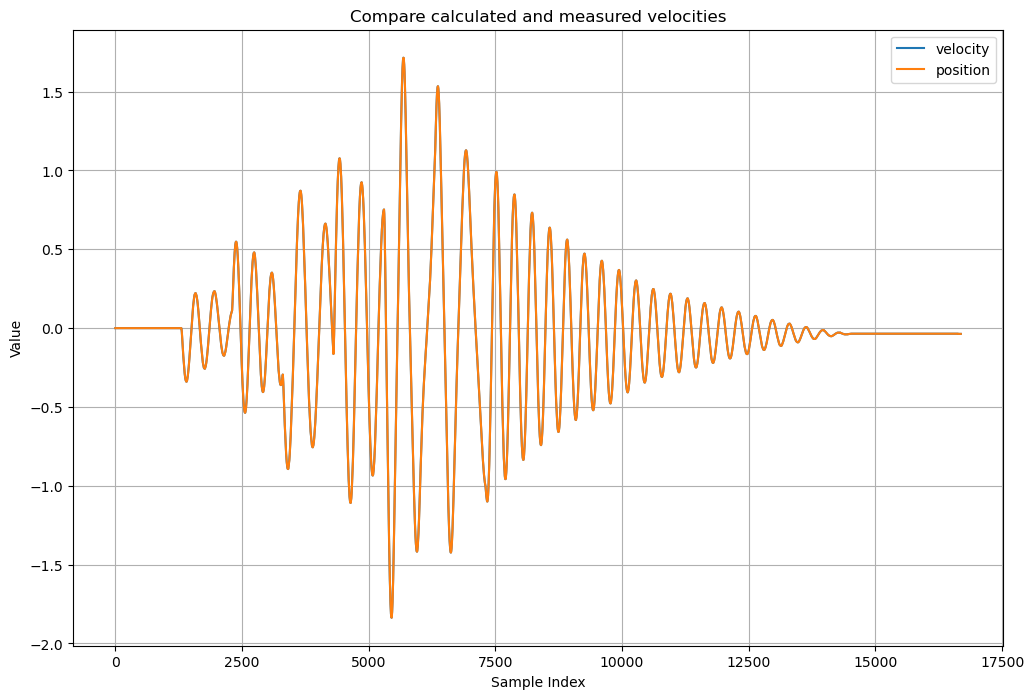

In [5]:
# Create vectors of X and Y values
all_x_values = []
all_y_values = []
for i in range(int(len(dataset))):
    x_data, y_data = dataset[i]
    all_x_values.append(x_data.numpy())
    all_y_values.append(y_data.numpy())

# Plot all X values
plt.figure(figsize=(12, 8))

for i in [1]:
    plt.plot([x[i] for x in all_x_values], label=x_columns[i].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Plot of all X values")
plt.legend()
plt.grid(True)
plt.show()

# Plot all Y values
plt.figure(figsize=(12, 8))

for i in range(len(y_columns)):
    plt.plot([y[i] for y in all_y_values], label=y_labels[i].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Plot of all Y values")
plt.legend()
plt.grid(True)
plt.show()

# Plot all Y values
plt.figure(figsize=(12, 8))

i = 0
plt.plot([y[i] for y in all_y_values], label=y_labels[i].split("/")[-1])
plt.plot([x[i + 1] for x in all_x_values], label=x_columns[i + 1].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Compare calculated and measured velocities")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))

i = 2
plt.plot([y[i] for y in all_y_values], label=y_labels[i].split("/")[-1])
plt.plot([x[i + 1] for x in all_x_values], label=x_columns[i + 1].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Compare calculated and measured velocities")
plt.legend()
plt.grid(True)
plt.show()

# Training neural net

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming your dataset is already defined
if torch.cuda.is_available():
    dataset = [(inputs.to(device), targets.to(device)) for inputs, targets in dataset]


class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(
            input_size, 512
        )  # Increase the size of the first hidden layer
        self.fc2 = nn.Linear(512, 512)  # Add another hidden layer
        self.fc3 = nn.Linear(512, 512)  # Add another hidden layer
        self.fc4 = nn.Linear(512, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Define the input and output sizes
input_size = len(dataset[0][0])
output_size = len(dataset[0][1])

# Create the neural network
model = SimpleNN(input_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Define the data loader
dataloader = DataLoader(dataset, batch_size=250, shuffle=False)

# TensorBoard writer
writer = SummaryWriter()

# Train the neural network
num_epochs = 2000
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss}")

    # Write loss to TensorBoard
    writer.add_scalar("Loss/train", running_loss, epoch)

print("Finished Training")

# Close TensorBoard writer
writer.close()

Epoch 1, Loss: 293.6228153410384
Epoch 2, Loss: 136.99216675758362
Epoch 3, Loss: 37.24735627416521
Epoch 4, Loss: 50.82960592710879
Epoch 5, Loss: 71.60901865025517
Epoch 6, Loss: 49.8126262628939
Epoch 7, Loss: 56.734355291351676
Epoch 8, Loss: 51.39551348891109
Epoch 9, Loss: 49.351462967228144
Epoch 10, Loss: 49.48531961347908
Epoch 11, Loss: 65.20978985592956
Epoch 12, Loss: 46.49615937517956
Epoch 13, Loss: 60.20640666142572
Epoch 14, Loss: 20.059280020417646
Epoch 15, Loss: 18.122176002929336
Epoch 16, Loss: 55.13089554356702
Epoch 17, Loss: 28.824809387442656
Epoch 18, Loss: 23.00351613177918
Epoch 19, Loss: 31.91117415095505
Epoch 20, Loss: 40.387715289136395
Epoch 21, Loss: 33.443047612090595
Epoch 22, Loss: 58.685867049964145
Epoch 23, Loss: 46.36720641865395
Epoch 24, Loss: 37.91428412584355
Epoch 25, Loss: 17.36807796760695
Epoch 26, Loss: 24.094808653309883
Epoch 27, Loss: 20.22018080293492
Epoch 28, Loss: 22.81102564118919
Epoch 29, Loss: 11.282592467963696
Epoch 30, Los

In [31]:
def simulate(T):
    out = []
    x = torch.tensor([0.0, 0.0, 0.0, 0.0]).to(device)
    for i in range(T):
        out.append(x.cpu().detach().numpy())
        x = model(
            torch.cat((torch.tensor([dataset[i][0][0]]).to(device), x)).to(device)
        )
    return out


out = simulate(1000)

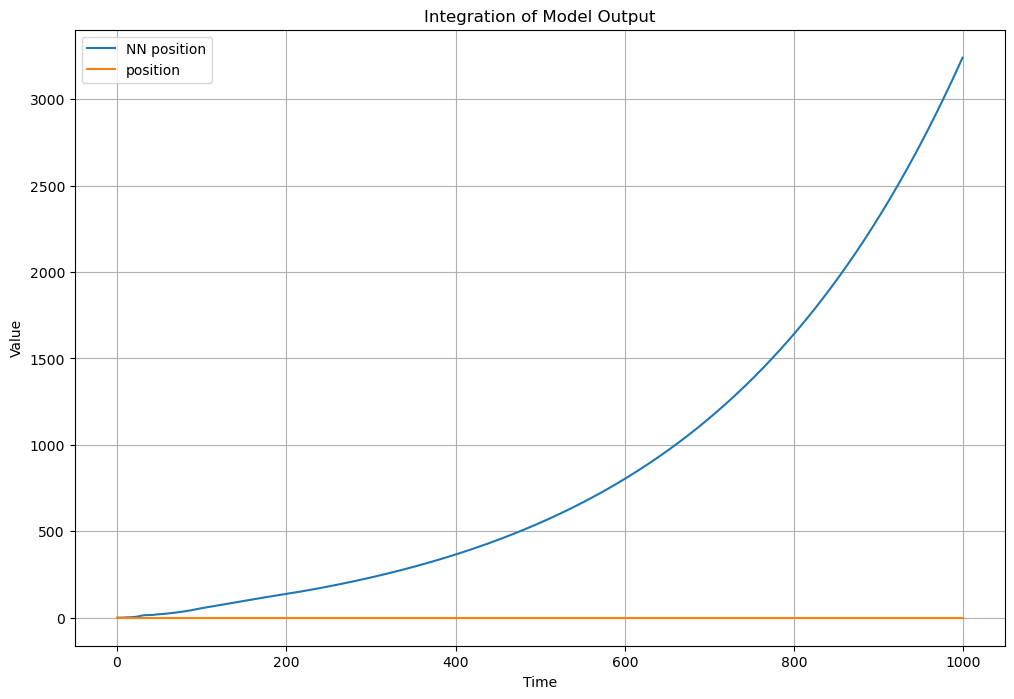

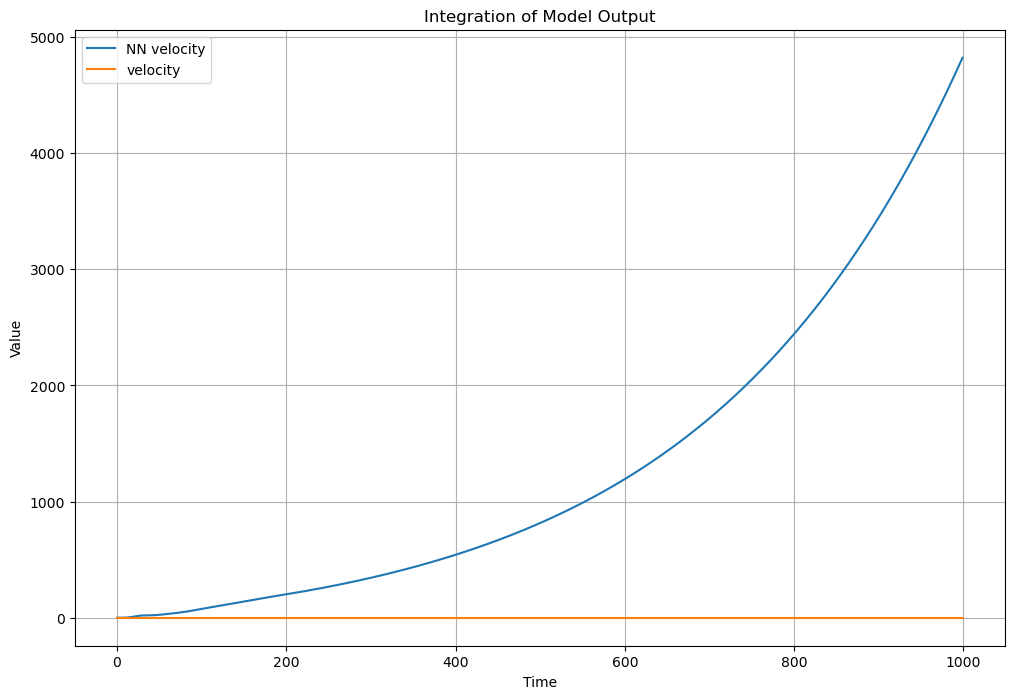

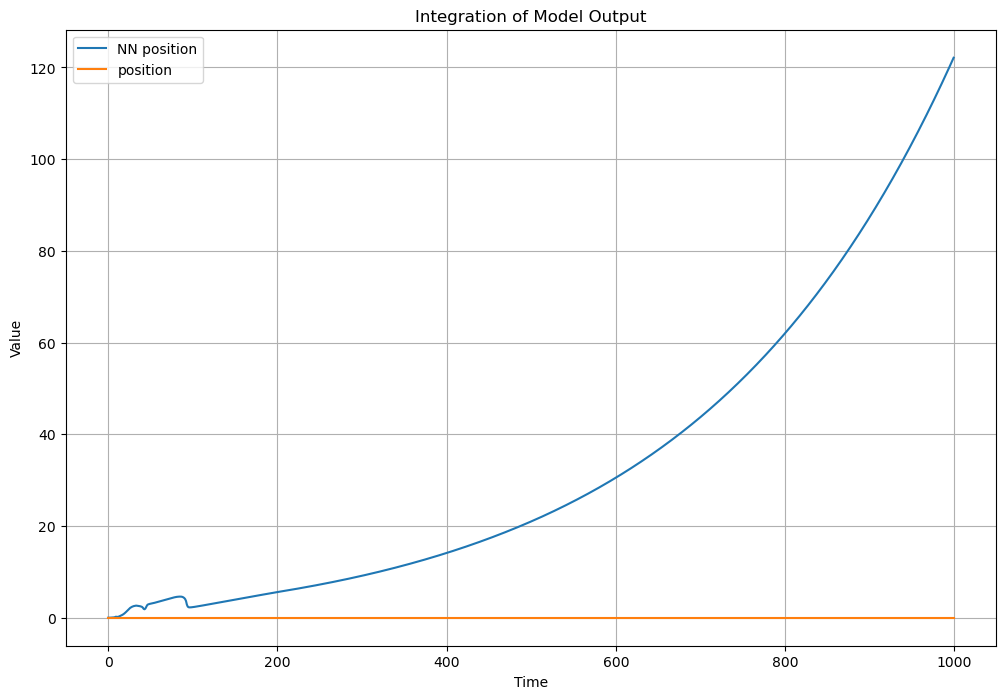

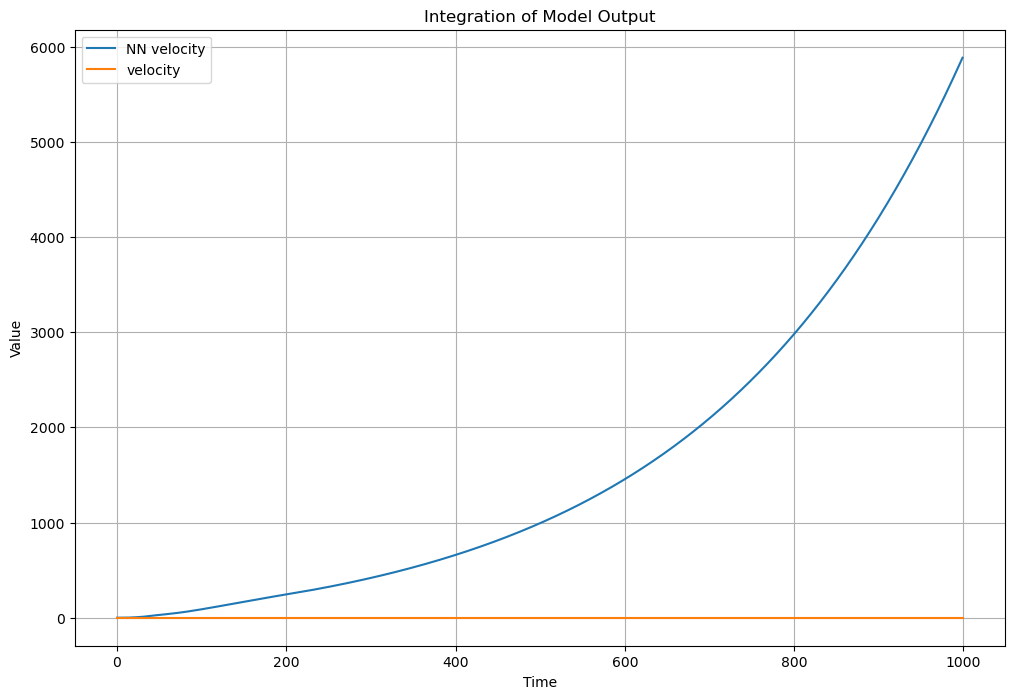

In [32]:
# Plot the results
for i in range(len(out[0])):
    plt.figure(figsize=(12, 8))

    offset = 0
    idx = i + 1
    plt.plot(
        range(offset, len(out) + offset),
        [x[i] for x in out],
        label="NN " + x_columns[idx].split("/")[-1],
    )
    plt.plot(
        range(0, len(out)),
        [all_x_values[j][idx] for j in range(len(out))],
        label=x_columns[idx].split("/")[-1],
    )

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Integration of Model Output")
    plt.legend()
    plt.grid(True)
    plt.show()